In [ ]:
!pip install insightface opencv-python numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 6.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 48.4 MB/s eta 0:00:00
  Created wheel for insightface: filename=insightface-0.7.3-cp311-cp311-linux_x86_64.whl size=1064926 sha256=6e2f88ae31eace9660077030a64a6df2f61096ce5b5e176e7653dea074f7ad2a
  Stored in directory: /root/.cache/pip/wheels/27/d8/22/f52d858d16cd06e7b2e6aad34a1777dcfaf000be833bbf8146
Successfully built insightface


In [ ]:
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 87.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.5 MB/s eta 0:00:00


In [ ]:
import sqlite3  # For database management
import cv2  # OpenCV for image processing
import numpy as np  # Numerical computing
from insightface.app import FaceAnalysis  # InsightFace for facial recognition
import os  # For handling files
from datetime import datetime  # To track dates

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.4' (you have '2.0.3'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
# Connect to SQLite database (creates a file named attendance.db)
conn = sqlite3.connect('attendance.db')
cursor = conn.cursor()

# Create 'students' table
cursor.execute('''
CREATE TABLE IF NOT EXISTS students (
    student_id INTEGER PRIMARY KEY AUTOINCREMENT,
    name TEXT NOT NULL,
    photo_path TEXT NOT NULL
)
''')

# Create 'attendance' table
cursor.execute('''
CREATE TABLE IF NOT EXISTS attendance (
    attendance_id INTEGER PRIMARY KEY AUTOINCREMENT,
    student_id INTEGER,
    date TEXT,
    status TEXT,
    FOREIGN KEY (student_id) REFERENCES students (student_id)
)
''')

conn.commit()
conn.close()

print("Database and tables created successfully.")

Database and tables created successfully.


In [ ]:
import sqlite3

# Connect to the SQLite database
conn = sqlite3.connect('Attendance.db')
cursor = conn.cursor()

# Create the students table if it doesn't exist
cursor.execute('''
    CREATE TABLE IF NOT EXISTS students (
        student_id INTEGER PRIMARY KEY,
        name TEXT NOT NULL,
        photo_path TEXT NOT NULL
    )
''')

# Save changes
conn.commit()

In [ ]:
import sqlite3

# Connect to database
conn = sqlite3.connect('Attendance.db')
cursor = conn.cursor()

# Function to add a student
def add_student(student_id, name, photo_path):
    try:
        cursor.execute('''
        INSERT INTO students (student_id, name, photo_path)
        VALUES (?, ?, ?)
        ''', (student_id, name, photo_path))
        conn.commit()
        print(f"Student {name} added successfully.")
    except sqlite3.IntegrityError:
        print(f"Error: Student ID {student_id} already exists.")

In [ ]:
add_student(1, 'Draco', '/content/draco.png')
add_student(2, 'Hermione', '/content/hermione.png')
add_student(3, 'Harry', '/content/harry.png')
add_student(4, 'Ron', '/content/ron.png')
add_student(5, 'Neville', '/content/neville.png')

Student Draco added successfully.
Student Hermione added successfully.
Student Harry added successfully.
Student Ron added successfully.
Student Neville added successfully.


In [ ]:
# Load InsightFace model
face_app = FaceAnalysis(providers=['CPUExecutionProvider'])  # Using CPU
face_app.prepare(ctx_id=0, det_size=(640, 640))

print("InsightFace model loaded successfully.")

download_path: /root/.insightface/models/buffalo_l


100%|██████████| 281857/281857 [00:06<00:00, 44022.40KB/s]


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
InsightFace 

In [ ]:
# Dictionary to store student embeddings
student_embeddings = {}

# Function to process and encode student faces
def encode_student_faces():
    conn = sqlite3.connect('attendance.db')
    cursor = conn.cursor()

    cursor.execute("SELECT student_id, name, photo_path FROM students")
    students = cursor.fetchall()

    for student_id, name, photo_path in students:
        img = cv2.imread(photo_path)
        if img is None:
            print(f"Could not load image for {name}")
            continue

        faces = face_app.get(img)
        if len(faces) == 0:
            print(f"No face detected for {name}")
            continue

        embedding = faces[0].embedding / np.linalg.norm(faces[0].embedding)  # Normalize
        student_embeddings[student_id] = embedding

    conn.close()
    print("All student faces encoded successfully.")

# Run the function
encode_student_faces()

All student faces encoded successfully.


In [ ]:
from google.colab import files

uploaded = files.upload()

Saving hpgrouppic.png to hpgrouppic (1).png


In [ ]:
def recognize_faces(classroom_image_path):
    img = cv2.imread(classroom_image_path)
    if img is None:
        print("Could not load classroom image.")
        return []

    faces = face_app.get(img)  # Detect faces

    recognized_students = []

    for face in faces:
        embedding = face.embedding / np.linalg.norm(face.embedding)  # Normalize

        for student_id, student_embedding in student_embeddings.items():
            similarity = np.dot(embedding, student_embedding)  # Cosine similarity

            if similarity > 0.6:  # Threshold for matching
                recognized_students.append(student_id)

    return recognized_students

# Example usage
recognized_students = recognize_faces("/content/classroom_photo.jpg")
print("Recognized student IDs:", recognized_students)

Could not load classroom image.
Recognized student IDs: []


In [ ]:
import os
print("Uploaded files:", os.listdir("/content"))

Uploaded files: ['.config', 'draco.png', 'hpgrouppic (1).png', 'hermione.png', 'image.webp', 'hpgrouppic.png', 'ron.png', 'neville.png', 'harry.png', 'hpgroup.webp', 'attendance.db', 'Attendance.db', 'sample_data']


In [ ]:
import cv2

image_path = "/content/hpgrouppic.png"  # Replace with the exact file name from Step 1
img = cv2.imread(image_path)

if img is None:
    print("Could not load image. Check if the file path is correct.")
else:
    print("Image loaded successfully!")

Image loaded successfully!


In [ ]:
# Convert to RGB (from BGR, OpenCV’s default)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
faces = face_app.get(img_rgb)

/usr/local/lib/python3.11/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


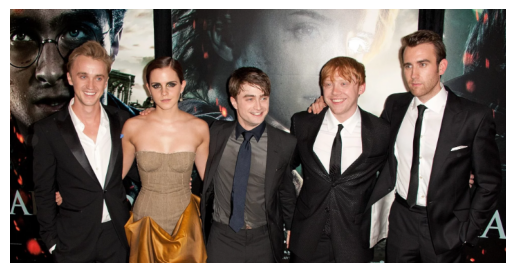

In [ ]:
import cv2
import matplotlib.pyplot as plt

image_path = "/content/hpgrouppic.png"  # Use the exact file name you got from `os.listdir()`
img = cv2.imread(image_path)

# If the image loads successfully, display it using matplotlib to ensure it's visible
if img is not None:
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for displaying
    plt.imshow(img_rgb)
    plt.axis('off')  # Hide axes
    plt.show()
else:
    print("Could not load image. Please check the file path and format.")

In [ ]:
faces = face_app.get(img)  # Detect faces
print(f"Detected faces: {len(faces)}")

if len(faces) > 0:
    print("Faces detected successfully!")
else:
    print("No faces detected.")

Detected faces: 6
Faces detected successfully!


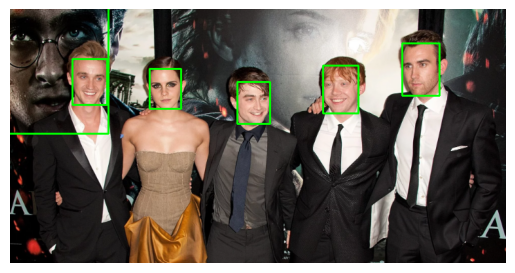

In [ ]:
# prompt: highlight detected faces

import cv2
import matplotlib.pyplot as plt

image_path = "/content/hpgrouppic.png"  # Use the exact file name you got from `os.listdir()`
img = cv2.imread(image_path)

# If the image loads successfully, display it using matplotlib to ensure it's visible
if img is not None:
    for face in faces:
        bbox = face.bbox.astype(int)
        cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for displaying
    plt.imshow(img_rgb)
    plt.axis('off')  # Hide axes
    plt.show()
else:
    print("Could not load image. Please check the file path and format.")


In [ ]:
# Print the embeddings for each face
for student_id, student_embedding in student_embeddings.items():
    print(f"Student ID {student_id} embedding: {student_embedding}")

# Print the embedding for the recognized faces
for face in faces:
    embedding = face.embedding / np.linalg.norm(face.embedding)  # Normalize
    print(f"Detected face embedding: {embedding}")

Detected face embedding: [ 3.00272070e-02 -2.06444543e-02  3.25789093e-03  8.48768950e-02
  9.63295810e-03  9.99445282e-03 -4.09562699e-02  3.54233384e-02
 -5.68298064e-02  6.73229098e-02  1.03407562e-01 -3.39123756e-02
  2.59765028e-03 -3.60145010e-02 -8.74718353e-02 -3.53970453e-02
 -5.20614488e-03  3.72138061e-02  1.00541618e-02  4.81894799e-02
  3.41320634e-02  6.73995586e-03  1.15707433e-02  3.56136598e-02
 -4.51748166e-03 -4.14249189e-02  1.30330557e-02  5.27083054e-02
 -4.06351238e-02  5.12320772e-02 -4.43118624e-02 -7.01653510e-02
 -4.68101948e-02 -1.23158883e-04 -5.49447490e-04 -2.51416769e-02
  3.44113857e-02  1.21379793e-02 -8.68177414e-02 -3.56064700e-02
 -1.23652304e-02 -7.91401416e-03 -2.89980900e-02  5.20088989e-03
  5.43353185e-02  8.63575190e-02  6.19240403e-02 -5.71397319e-02
  6.18883856e-02  5.15614785e-02 -7.81431869e-02  8.97373110e-02
  6.36610687e-02 -4.75327559e-02 -2.66899504e-02  1.47581212e-02
  5.87792546e-02 -3.72864492e-03 -1.66774951e-02 -2.82347724e-02


In [ ]:
if similarity > 0.5:  # Adjust the threshold to 0.5 for a broader match
    recognized_students.append(student_id)

NameError: name 'similarity' is not defined

In [ ]:
def recognize_faces(classroom_image_path):
    img = cv2.imread(classroom_image_path)
    if img is None:
        print("Could not load classroom image.")
        return []

    faces = face_app.get(img)  # Detect faces

    recognized_students = []

    print(f"Detected faces: {len(faces)}")
    print("Detected face embeddings:")

    # Loop over detected faces and print their embeddings
    for face in faces:
        embedding = face.embedding / np.linalg.norm(face.embedding)  # Normalize
        print(embedding)  # Print the embedding for debugging

        for student_id, student_embedding in student_embeddings.items():
            similarity = np.dot(embedding, student_embedding)  # Cosine similarity
            print(f"Comparing with student {student_id}: similarity = {similarity}")

            if similarity > 0.5:  # Adjust the threshold to 0.5 for a broader match
                recognized_students.append(student_id)

    return recognized_students

# Example usage
recognized_students = recognize_faces("/content/classroom_photo.jpg")
print("Recognized student IDs:", recognized_students)

Could not load classroom image.
Recognized student IDs: []


In [ ]:
print(f"Image path: {classroom_image_path}")

Image path: /content/hpgrouppic.png


In [ ]:
classroom_image_path = "/content/hpgrouppic.png"
print(f"Image path: {classroom_image_path}")  # Debugging step
recognized_students = recognize_faces(classroom_image_path)

Image path: /content/hpgrouppic.png
Detected faces: 6
Detected face embeddings:
[ 3.00272070e-02 -2.06444543e-02  3.25789093e-03  8.48768950e-02
  9.63295810e-03  9.99445282e-03 -4.09562699e-02  3.54233384e-02
 -5.68298064e-02  6.73229098e-02  1.03407562e-01 -3.39123756e-02
  2.59765028e-03 -3.60145010e-02 -8.74718353e-02 -3.53970453e-02
 -5.20614488e-03  3.72138061e-02  1.00541618e-02  4.81894799e-02
  3.41320634e-02  6.73995586e-03  1.15707433e-02  3.56136598e-02
 -4.51748166e-03 -4.14249189e-02  1.30330557e-02  5.27083054e-02
 -4.06351238e-02  5.12320772e-02 -4.43118624e-02 -7.01653510e-02
 -4.68101948e-02 -1.23158883e-04 -5.49447490e-04 -2.51416769e-02
  3.44113857e-02  1.21379793e-02 -8.68177414e-02 -3.56064700e-02
 -1.23652304e-02 -7.91401416e-03 -2.89980900e-02  5.20088989e-03
  5.43353185e-02  8.63575190e-02  6.19240403e-02 -5.71397319e-02
  6.18883856e-02  5.15614785e-02 -7.81431869e-02  8.97373110e-02
  6.36610687e-02 -4.75327559e-02 -2.66899504e-02  1.47581212e-02
  5.877925

In [ ]:
def recognize_faces(classroom_image_path):
    print(f"Image path: {classroom_image_path}")  # Debugging step
    img = cv2.imread(classroom_image_path)
    if img is None:
        print("Could not load classroom image.")
        return []

    faces = face_app.get(img)  # Detect faces
    print(f"Detected faces: {len(faces)}")  # Debugging step

    recognized_students = []

    for face in faces:
        embedding = face.embedding / np.linalg.norm(face.embedding)  # Normalize

        for student_id, student_embedding in student_embeddings.items():
            similarity = np.dot(embedding, student_embedding)  # Cosine similarity

            if similarity > 0.5:  # Adjust the threshold to 0.5 for a broader match
                recognized_students.append(student_id)

    return recognized_students

In [ ]:
import os
print(os.path.exists(classroom_image_path))

True


In [ ]:
print(f"Draco's image from {'/content/draco.png'}")

Draco's image from /content/draco.png


In [ ]:
def recognize_faces(classroom_image_path):
    img = cv2.imread(classroom_image_path)
    if img is None:
        print(f"Could not load classroom image: {classroom_image_path}")
        return []

    faces = face_app.get(img)  # Detect faces
    print(f"Detected faces: {len(faces)}")

    recognized_students = []

    for face in faces:
        embedding = face.embedding / np.linalg.norm(face.embedding)  # Normalize

        for student_id, student_embedding in student_embeddings.items():
            similarity = np.dot(embedding, student_embedding)  # Cosine similarity
            print(f"Similarity for student {student_id}: {similarity}")

            if similarity > 0.5:  # Adjust the threshold
                recognized_students.append(student_id)

    return recognized_students

# Example usage
recognized_students = recognize_faces("/content/hpgrouppic.png")
print("Recognized student IDs:", recognized_students)

Detected faces: 6
Recognized student IDs: []


In [ ]:
def recognize_faces(classroom_image_path):
    img = cv2.imread(classroom_image_path)
    if img is None:
        print(f"Could not load classroom image: {classroom_image_path}")
        return []

    faces = face_app.get(img)  # Detect faces
    print(f"Detected faces: {len(faces)}")

    recognized_students = []

    for face in faces:
        embedding = face.embedding / np.linalg.norm(face.embedding)  # Normalize

        for student_id, student_embedding in student_embeddings.items():
            print(f"Comparing face to student {student_id}")
            similarity = np.dot(embedding, student_embedding)  # Cosine similarity
            print(f"Similarity for student {student_id}: {similarity}")

            if similarity > 0.3:  # Adjust the threshold to a lower value
                recognized_students.append(student_id)

    return recognized_students


In [ ]:
recognized_students = recognize_faces("/content/hpgrouppic.png")  # Path to your classroom image
print("Recognized student IDs:", recognized_students)

Detected faces: 6
Face embedding: [ 3.00272070e-02 -2.06444543e-02  3.25789093e-03  8.48768950e-02
  9.63295810e-03  9.99445282e-03 -4.09562699e-02  3.54233384e-02
 -5.68298064e-02  6.73229098e-02  1.03407562e-01 -3.39123756e-02
  2.59765028e-03 -3.60145010e-02 -8.74718353e-02 -3.53970453e-02
 -5.20614488e-03  3.72138061e-02  1.00541618e-02  4.81894799e-02
  3.41320634e-02  6.73995586e-03  1.15707433e-02  3.56136598e-02
 -4.51748166e-03 -4.14249189e-02  1.30330557e-02  5.27083054e-02
 -4.06351238e-02  5.12320772e-02 -4.43118624e-02 -7.01653510e-02
 -4.68101948e-02 -1.23158883e-04 -5.49447490e-04 -2.51416769e-02
  3.44113857e-02  1.21379793e-02 -8.68177414e-02 -3.56064700e-02
 -1.23652304e-02 -7.91401416e-03 -2.89980900e-02  5.20088989e-03
  5.43353185e-02  8.63575190e-02  6.19240403e-02 -5.71397319e-02
  6.18883856e-02  5.15614785e-02 -7.81431869e-02  8.97373110e-02
  6.36610687e-02 -4.75327559e-02 -2.66899504e-02  1.47581212e-02
  5.87792546e-02 -3.72864492e-03 -1.66774951e-02 -2.8234

In [ ]:
def recognize_faces(classroom_image_path):
    img = cv2.imread(classroom_image_path)
    if img is None:
        print(f"Could not load classroom image: {classroom_image_path}")
        return []

    faces = face_app.get(img)  # Detect faces
    print(f"Detected faces: {len(faces)}")

    recognized_students = []

    for face in faces:
        embedding = face.embedding / np.linalg.norm(face.embedding)  # Normalize
        print(f"Face embedding: {embedding}")  # Debugging face embedding

        for student_id, student_embedding in student_embeddings.items():
            print(f"Comparing face to student {student_id}")

            # Calculate similarity
            similarity = np.dot(embedding, student_embedding)  # Cosine similarity
            print(f"Similarity for student {student_id}: {similarity}")

            if similarity > 0.3:  # Adjust the threshold if necessary
                recognized_students.append(student_id)

    return recognized_students


In [ ]:
def recognize_faces(classroom_image_path):
    img = cv2.imread(classroom_image_path)
    if img is None:
        print(f"Could not load classroom image: {classroom_image_path}")
        return []

    faces = face_app.get(img)  # Detect faces
    print(f"Detected faces: {len(faces)}")

    recognized_students = []

    for face in faces:
        # Normalize and print face embedding
        embedding = face.embedding / np.linalg.norm(face.embedding)  # Normalize
        print(f"Face embedding: {embedding}")  # Debugging: face embedding from classroom image

        for student_id, student_embedding in student_embeddings.items():
            # Normalize and print stored student embedding
            student_embedding_normalized = student_embedding / np.linalg.norm(student_embedding)  # Normalize
            print(f"Student embedding for {student_id}: {student_embedding_normalized}")  # Debugging: stored student embedding

            # Calculate similarity
            similarity = np.dot(embedding, student_embedding_normalized)  # Cosine similarity
            print(f"Similarity for student {student_id}: {similarity}")

            if similarity > 0.3:  # Adjust the threshold if necessary
                recognized_students.append(student_id)

    return recognized_students


In [ ]:
def recognize_faces(classroom_image_path):
    img = cv2.imread(classroom_image_path)
    if img is None:
        print(f"Could not load classroom image: {classroom_image_path}")
        return []

    faces = face_app.get(img)  # Detect faces
    print(f"Detected faces: {len(faces)}")

    if len(faces) == 0:
        print("No faces detected in the image.")
        return []

    recognized_students = []

    for face in faces:
        # Normalize and print face embedding
        embedding = face.embedding / np.linalg.norm(face.embedding)  # Normalize
        print(f"Face embedding: {embedding}")  # Debugging: face embedding from classroom image

        for student_id, student_embedding in student_embeddings.items():
            # Normalize and print stored student embedding
            student_embedding_normalized = student_embedding / np.linalg.norm(student_embedding)  # Normalize
            print(f"Student embedding for {student_id}: {student_embedding_normalized}")  # Debugging: stored student embedding

            # Calculate similarity
            similarity = np.dot(embedding, student_embedding_normalized)  # Cosine similarity
            print(f"Similarity for student {student_id}: {similarity}")

            if similarity > 0.3:  # Adjust the threshold if necessary
                recognized_students.append(student_id)

    return recognized_students

    # Example usage
recognized_students = recognize_faces("/content/hpgrouppic.png")  # Path to your classroom image
print("Recognized student IDs:", recognized_students)


Detected faces: 6
Face embedding: [ 3.00272070e-02 -2.06444543e-02  3.25789093e-03  8.48768950e-02
  9.63295810e-03  9.99445282e-03 -4.09562699e-02  3.54233384e-02
 -5.68298064e-02  6.73229098e-02  1.03407562e-01 -3.39123756e-02
  2.59765028e-03 -3.60145010e-02 -8.74718353e-02 -3.53970453e-02
 -5.20614488e-03  3.72138061e-02  1.00541618e-02  4.81894799e-02
  3.41320634e-02  6.73995586e-03  1.15707433e-02  3.56136598e-02
 -4.51748166e-03 -4.14249189e-02  1.30330557e-02  5.27083054e-02
 -4.06351238e-02  5.12320772e-02 -4.43118624e-02 -7.01653510e-02
 -4.68101948e-02 -1.23158883e-04 -5.49447490e-04 -2.51416769e-02
  3.44113857e-02  1.21379793e-02 -8.68177414e-02 -3.56064700e-02
 -1.23652304e-02 -7.91401416e-03 -2.89980900e-02  5.20088989e-03
  5.43353185e-02  8.63575190e-02  6.19240403e-02 -5.71397319e-02
  6.18883856e-02  5.15614785e-02 -7.81431869e-02  8.97373110e-02
  6.36610687e-02 -4.75327559e-02 -2.66899504e-02  1.47581212e-02
  5.87792546e-02 -3.72864492e-03 -1.66774951e-02 -2.8234

In [ ]:
def mark_attendance(recognized_students):
    conn = sqlite3.connect('attendance.db')
    cursor = conn.cursor()

    today = datetime.today().strftime('%Y-%m-%d')

    for student_id in recognized_students:
        cursor.execute("SELECT * FROM attendance WHERE student_id=? AND date=?", (student_id, today))
        if cursor.fetchone() is None:
            cursor.execute("INSERT INTO attendance (student_id, date, status) VALUES (?, ?, 'Present')", (student_id, today))

    conn.commit()
    conn.close()
    print("Attendance marked successfully.")

# Run the function
mark_attendance(recognized_students)

Attendance marked successfully.


In [ ]:
def daily_attendance_report():
    conn = sqlite3.connect('attendance.db')
    cursor = conn.cursor()

    today = datetime.today().strftime('%Y-%m-%d')
    cursor.execute("SELECT students.name, attendance.status FROM students JOIN attendance ON students.student_id = attendance.student_id WHERE attendance.date=?", (today,))

    report = cursor.fetchall()
    conn.close()

    for row in report:
        print(row[0], "-", row[1])

# Run the report
daily_attendance_report()

In [ ]:
# prompt: make a table for attendance based on the group image

import pandas as pd

def generate_attendance_table(recognized_students):
    """Generates a Pandas DataFrame for attendance based on recognized students.

    Args:
      recognized_students: A list of student IDs recognized in the image.

    Returns:
      A Pandas DataFrame representing the attendance table.
    """

    conn = sqlite3.connect('attendance.db')
    cursor = conn.cursor()

    today = datetime.today().strftime('%Y-%m-%d')

    # Fetch student information for recognized students
    student_data = []
    for student_id in recognized_students:
        cursor.execute("SELECT student_id, name FROM students WHERE student_id=?", (student_id,))
        student_info = cursor.fetchone()
        if student_info:
            student_data.append(student_info)

    # Create a list to store attendance records
    attendance_records = []
    for student_id, name in student_data:
        attendance_records.append({
            'Student ID': student_id,
            'Name': name,
            'Date': today,
            'Status': 'Present'
        })

    # Create a Pandas DataFrame from the attendance records
    attendance_df = pd.DataFrame(attendance_records)

    conn.close()
    return attendance_df

# Example usage
recognized_students = recognize_faces("/content/hpgrouppic.png")
attendance_table = generate_attendance_table(recognized_students)

# Display the attendance table
attendance_table


/usr/local/lib/python3.11/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


Detected faces: 6
Face embedding: [ 3.00272070e-02 -2.06444543e-02  3.25789093e-03  8.48768950e-02
  9.63295810e-03  9.99445282e-03 -4.09562699e-02  3.54233384e-02
 -5.68298064e-02  6.73229098e-02  1.03407562e-01 -3.39123756e-02
  2.59765028e-03 -3.60145010e-02 -8.74718353e-02 -3.53970453e-02
 -5.20614488e-03  3.72138061e-02  1.00541618e-02  4.81894799e-02
  3.41320634e-02  6.73995586e-03  1.15707433e-02  3.56136598e-02
 -4.51748166e-03 -4.14249189e-02  1.30330557e-02  5.27083054e-02
 -4.06351238e-02  5.12320772e-02 -4.43118624e-02 -7.01653510e-02
 -4.68101948e-02 -1.23158883e-04 -5.49447490e-04 -2.51416769e-02
  3.44113857e-02  1.21379793e-02 -8.68177414e-02 -3.56064700e-02
 -1.23652304e-02 -7.91401416e-03 -2.89980900e-02  5.20088989e-03
  5.43353185e-02  8.63575190e-02  6.19240403e-02 -5.71397319e-02
  6.18883856e-02  5.15614785e-02 -7.81431869e-02  8.97373110e-02
  6.36610687e-02 -4.75327559e-02 -2.66899504e-02  1.47581212e-02
  5.87792546e-02 -3.72864492e-03 -1.66774951e-02 -2.8234

""


In [ ]:
import cv2
import numpy as np
import insightface

# Load face recognition model
face_app = insightface.app.FaceAnalysis()
face_app.prepare(ctx_id=0, det_size=(640, 640))

# Student database (this should be populated before running the recognition)
student_embeddings = {
    1: np.random.rand(512),  # Placeholder example, use actual embeddings
    2: np.random.rand(512),
    3: np.random.rand(512),
    4: np.random.rand(512),
    5: np.random.rand(512),
}

def recognize_faces(classroom_image_path, output_image_path):
    img = cv2.imread(classroom_image_path)
    if img is None:
        print(f"Could not load classroom image: {classroom_image_path}")
        return []

    # Detect faces
    faces = face_app.get(img)
    print(f"Detected faces: {len(faces)}")

    if len(faces) == 0:
        print("No faces detected in the image.")
        return []

    # Draw bounding boxes around faces in the image
    for face in faces:
        if face.det_box is not None:
            bbox = face.det_box.astype(int)
            cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)

    # Save the image with highlighted faces
    cv2.imwrite(output_image_path, img)
    print(f"Image with highlighted faces saved to: {output_image_path}")

    # Show image with bounding boxes (optional)
    cv2.imshow("Detected Faces", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    recognized_students = []

    for face in faces:
        if face.embedding is not None:
            embedding = face.embedding / np.linalg.norm(face.embedding)  # Normalize
            print(f"Face embedding: {embedding}")

            for student_id, student_embedding in student_embeddings.items():
                # Compare face embedding to student embeddings using cosine similarity
                similarity = np.dot(embedding, student_embedding)  # Cosine similarity
                print(f"Similarity for student {student_id}: {similarity}")

                # Adjust threshold for matching
                if similarity > 0.3:
                    recognized_students.append(student_id)

    return recognized_students

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


This work is quite messy, but you should see model setup and training at the beginning of the code, follwed by image processing and testing with group/individual images (there will be a LOT of that), then documentation and explanation will be in my report, and in this text. I've also highlighted innovation and improvements to the system that I found in my report, and are in this code as well!